# Help Twitter Combat Hate Speech Using NLP and Machine Learning

<b>DESCRIPTION

Using NLP and ML, make a model to identify hate speech (racist or sexist tweets) in Twitter.

<b>Problem Statement:  

Twitter is the biggest platform where anybody and everybody can have their views heard. Some of these voices spread hate and negativity. Twitter is wary of its platform being used as a medium  to spread hate. 

You are a data scientist at Twitter, and you will help Twitter in identifying the tweets with hate speech and removing them from the platform. You will use NLP techniques, perform specific cleanup for tweets data, and make a robust model.

<b>Domain:</b> Social Media

<b>Analysis to be done:</b> Clean up tweets and build a classification model by using NLP techniques, cleanup specific for tweets data, regularization and hyperparameter tuning using stratified k-fold and cross validation to get the best model.

<b>Content: 

id: identifier number of the tweet

Label: 0 (non-hate) /1 (hate)

Tweet: the text in the tweet

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import nltk
import re
import string
import warnings
warnings.filterwarnings('ignore')

### 1. Load the tweets file using read_csv function from Pandas package. 

In [3]:
data = pd.read_csv('TwitterHate.csv', encoding="utf-8")
data.head(3)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty


In [4]:
data.shape

(31962, 3)

In [5]:
data.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

### 2. Get the tweets into a list for easy text cleanup and manipulation.

In [6]:
data = data[['tweet', 'label']]

In [7]:
data.shape

(31962, 2)

In [8]:
data.isnull().sum()

tweet    0
label    0
dtype: int64

In [9]:
data.head(3)

,tweet,label
0,@user when a father is dysfunctional and is s...,0
1,@user @user thanks for #lyft credit i can't us...,0
2,bihday your majesty,0




### 3. To cleanup: 

    1. Normalize the casing.

    2. Using regular expressions, remove user handles. These begin with '@’.

    3. Using regular expressions, remove URLs.

    4. Using TweetTokenizer from NLTK, tokenize the tweets into individual terms.

    5. Remove stop words.

    6. Remove redundant terms like ‘amp’, ‘rt’, etc.

    7. Remove ‘#’ symbols from the tweet while retaining the term.

In [10]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [11]:
from nltk.tokenize import TweetTokenizer 

In [12]:
def preprocess_tweet_text(tweet):
    # Normalize the casing.
    tweet.lower()    
    
    tweet = re.sub('[^A-Za-z0-9]+', ' ', tweet)
    
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    
    #Using TweetTokenizer from NLTK, tokenize the tweets into individual terms.
    tk = TweetTokenizer()
    tweet_tokens = tk.tokenize(tweet) 
    
    # Remove stopwords
    filtered_words = [w for w in tweet_tokens if not w in stop_words] 
    
    # Remove redundant terms like ‘amp’, ‘rt’, etc.    
    filtered_words_final = [w for w in filtered_words if not w in ('amp', 'rt')]   
                
    return " ".join(filtered_words_final)

In [13]:
data.tweet = data['tweet'].apply(preprocess_tweet_text)

In [14]:
data.head(3)

,tweet,label
0,user father dysfunctional selfish drags kids d...,0
1,user user thanks lyft credit use cause offer w...,0
2,bihday majesty,0


### 4. Extra cleanup by removing terms with a length of 1.

In [15]:
data['length']= data['tweet'].apply(len)
data.head(3)

,tweet,label,length
0,user father dysfunctional selfish drags kids d...,0,60
1,user user thanks lyft credit use cause offer w...,0,87
2,bihday majesty,0,14


In [16]:
data.shape

(31962, 3)

In [17]:
len(data[data['length'] == 0])

11

In [18]:
len(data[data['length'] == 1])

2

In [19]:
len(data[data['length']>1])

31949

In [20]:
data[data['length'] == 0]

,tweet,label,length
3351,,0,0
7222,,0,0
10461,,0,0
13038,,0,0
15434,,0,0
16250,,0,0
20261,,0,0
22709,,0,0
25629,,1,0
29803,,1,0


In [21]:
data = data[data['length']>1]

In [22]:
data.shape

(31949, 3)

In [23]:
data.head(3)

,tweet,label,length
0,user father dysfunctional selfish drags kids d...,0,60
1,user user thanks lyft credit use cause offer w...,0,87
2,bihday majesty,0,14


### 5. Check out the top terms in the tweets:

    1. First, get all the tokenized terms into one large list.
    2. Use the counter and find the 10 most common terms.

In [24]:
def token_text(text):
    # tokenize the text into a list of words
    tokens = nltk.tokenize.word_tokenize(text)
    return tokens

In [25]:
# Final list with tokenized words
tokenized_large = []

# Iterating over each string in data
for x in data['tweet']:
    # Calliing preprocess text function
    token = token_text(x)

    tokenized_large.append(token) 

flattened_tokeninized_final = [i for j in tokenized_large for i in j]

In [26]:
type(flattened_tokeninized_final)

list

In [27]:
# Use the counter and find the 10 most common terms.
from collections import Counter
most_common_words= [word for word, word_count in Counter(flattened_tokeninized_final).most_common(10)]
print(most_common_words)

['user', 'love', 'day', 'happy', 'u', 'life', 'time', 'like', 'today', 'new']


### 6. Data formatting for predictive modeling:

    1. Join the tokens back to form strings. This will be required for the vectorizers.
    2. Assign x and y.
    3. Perform train_test_split using sklearn.

In [28]:
data.head()

,tweet,label,length
0,user father dysfunctional selfish drags kids d...,0,60
1,user user thanks lyft credit use cause offer w...,0,87
2,bihday majesty,0,14
3,model love u take u time ur,0,27
4,factsguide society motivation,0,29


In [29]:
data.shape

(31949, 3)

In [30]:
X = data['tweet']
Y = data['label']

In [31]:
# Splitting data into train and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y ,test_size=0.20, random_state=10)

### 7. We’ll use TF-IDF values for the terms as a feature to get into a vector space model.

    1. Import TF-IDF  vectorizer from sklearn.

    2. Instantiate with a maximum of 5000 terms in your vocabulary.

    3. Fit and apply on the train set.

    4. Apply on the test set.



In [32]:
# 1. Import TF-IDF  vectorizer from sklearn.
from sklearn.feature_extraction.text import TfidfVectorizer

In [33]:
# 2. Instantiate with a maximum of 5000 terms in your vocabulary.
tfidf_vect = TfidfVectorizer(max_features =5000)

In [34]:
# 3. Fit and apply on the train set.
X_train_tfidf = tfidf_vect.fit_transform(X_train)

In [35]:
# 4. Apply on the test set.
X_test_tfidf = tfidf_vect.transform(X_test)

### 8. Model building: Ordinary Logistic Regression

    1. Instantiate Logistic Regression from sklearn with default parameters.

    2. Fit into  the train data.

    3. Make predictions for the train and the test set.

In [36]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

In [37]:
lr.fit(X_train_tfidf, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [38]:
# Make predictions for the train and the test set.
predictions_train = lr.predict(X_train_tfidf)
predictions_test = lr.predict(X_test_tfidf)

### 9. Model evaluation: Accuracy, recall, and f_1 score.

    1. Report the accuracy on the train set.

    2. Report the recall on the train set: decent, high, or low.

    3. Get the f1 score on the train set.

In [39]:
from sklearn.metrics import classification_report, recall_score, accuracy_score, f1_score

In [40]:
print(classification_report(y_test, predictions_test))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5965
           1       0.93      0.35      0.51       425

    accuracy                           0.95      6390
   macro avg       0.94      0.67      0.74      6390
weighted avg       0.95      0.95      0.95      6390



In [41]:
print("Recall : ", recall_score(y_test, predictions_test))

Recall :  0.34823529411764703


Recall is 34%. ie Sensitivity or true positive rate is 34%, which is very low.

In [42]:
print("f1_score : ",f1_score(y_test, predictions_test))

f1_score :  0.5068493150684932


In [43]:
print(accuracy_score(y_test, predictions_test))

0.9549295774647887


### 10. Looks like you need to adjust the class imbalance, as the model seems to focus on the 0s.

    1. Adjust the appropriate class in the LogisticRegression model.



Text(0.5, 1.0, 'Distribution of label')

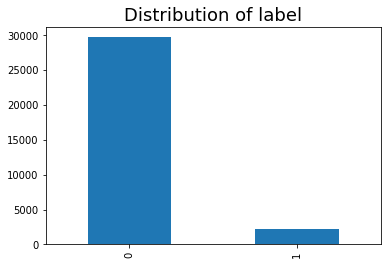

In [44]:
data['label'].value_counts().plot(kind='bar')
plt.title("Distribution of label", size=18)

In [45]:
# distribution
data['label'].value_counts()/data.shape[0]

0    0.929888
1    0.070112
Name: label, dtype: float64

In [46]:
# define class weights
w = {0:1, 1:92} # lable distribution % is 1:0==7:92

lr_2 = LogisticRegression(random_state=11, class_weight=w)

### 11. Train again with the adjustment and evaluate.

    1. Train the model on the train set.

    2. Evaluate the predictions on the train set: accuracy, recall, and f_1 score.



In [47]:
lr_2.fit(X_train_tfidf, y_train)

LogisticRegression(C=1.0, class_weight={0: 1, 1: 92}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=11, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [48]:
predictions_2 = lr_2.predict(X_test_tfidf)

In [49]:
print("Accuracy : ", accuracy_score(y_test, predictions_2))
print("  Recall : ", recall_score(y_test, predictions_2))
print("f1_score : ", f1_score(y_test, predictions_2))

Accuracy :  0.8539906103286385
  Recall :  0.8870588235294118
f1_score :  0.4469472436277415


### 12. Regularization and Hyperparameter tuning:

    1. Import GridSearch and StratifiedKFold because of class imbalance.

    2. Provide the parameter grid to choose for ‘C’ and ‘penalty’ parameters.

    3. Use a balanced class weight while instantiating the logistic regression.

In [50]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [51]:
C_val = np.arange(0.5, 20.0, 0.5)
penalty_val = ["l1", "l2"]

In [52]:
hyperparam_grid = {"penalty": penalty_val, "C": C_val }

In [53]:
lr_3 = LogisticRegression(random_state=11, class_weight=w)

### 13. Find the parameters with the best recall in cross validation.

    1. Choose ‘recall’ as the metric for scoring.

    2. Choose stratified 4 fold cross validation scheme.

    3. Fit into  the train set.

In [54]:
grid = GridSearchCV(lr_3, hyperparam_grid, scoring="recall", cv=4)

In [ ]:
grid.fit(X_train_tfidf, y_train)

### 14. What are the best parameters?

In [ ]:
print(f'Best recall: {grid.best_score_} with param: {grid.best_params_}')

### 15. Predict and evaluate using the best estimator.

    1. Use the best estimator from the grid search to make predictions on the test set.

    2. What is the recall on the test set for the toxic comments?

    3. What is the f_1 score?

In [ ]:
lr_4 = LogisticRegression(random_state=11, class_weight=w, C=0.5, penalty='l2')
lr_4.fit(X_train_tfidf, y_train)

In [ ]:
predictions = lr_4.predict(X_test_tfidf)

In [ ]:
print("Accuracy : ", accuracy_score(y_test, predictions))
print("  Recall : ", recall_score(y_test, predictions))
print("f1_score : ", f1_score(y_test, predictions))